# Global Country-wise Debt Analysis for the Past 5 Years

* 1: Define Scope
* Questions to address:
 - What are the global debt trends in the past 5 years?
 - How does the USA compare to other countries?
 - What potential risks and correlations exist between countries?



* 2. Import Required Libraries

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MinMaxScaler


In [7]:


# 3: Data Collection
# Load the provided files (World Bank and IMF datasets)
world_bank_data = pd.read_csv('E:\DataAnalyst_Projects\Debt analysis\data\world_bank.csv')
weo_data = pd.read_csv('E:\DataAnalyst_Projects\Debt analysis\data\cleaned_weo_data.csv')


In [8]:

# Inspect column names to verify correct formatting
print("World Bank Columns:", world_bank_data.columns)
print("IMF Columns:", weo_data.columns)

World Bank Columns: Index(['Country', 'Country Code', 'Indicator Name', 'Indicator Code', '1960',
       '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023',
       'Unnamed: 68', 'Region', 'IncomeGroup', 'SpecialNotes', 'TableName',
       'Unnamed: 5'],
      dtype='object')
IMF Columns: Index(['Country', 'Subject Descriptor', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2

In [9]:

# Display initial information about datasets
print("World Bank Data:")
print(world_bank_data.info())
print("\n IMF Data:")
print(weo_data.info())

World Bank Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 74 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            64 non-null     float64
 15  1971            66 non-null     float64
 16  1972            66 non-null     float64
 17  1973            66

In [10]:

# Step 4: Data Processing
# Harmonizing columns and identifying overlapping fields
world_bank_data.columns = world_bank_data.columns.str.lower().str.replace(' ', '_')
weo_data.columns = weo_data.columns.str.lower().str.replace(' ', '_')


In [11]:
# Inspect column names to verify correct formatting
print("World Bank Columns:", world_bank_data.columns)
print("IMF Columns:", weo_data.columns)


World Bank Columns: Index(['country', 'country_code', 'indicator_name', 'indicator_code', '1960',
       '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023',
       'unnamed:_68', 'region', 'incomegroup', 'specialnotes', 'tablename',
       'unnamed:_5'],
      dtype='object')
IMF Columns: Index(['country', 'subject_descriptor', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2

In [12]:
# Reshape World Bank data if necessary
if 'year' not in world_bank_data.columns:
    years = [str(year) for year in range(1960, 2024 + 1)]  # List of years as strings
    valid_years = [year for year in years if year in world_bank_data.columns]
    world_bank_data = world_bank_data.melt(
        id_vars=['country', 'country_code', 'indicator_name', 'indicator_code', 'region', 'incomegroup'],
        value_vars=valid_years,
        var_name='year',
        value_name='debt'
    )
    world_bank_data['year'] = world_bank_data['year'].astype(int)

# Reshape IMF data if necessary
if 'year' not in weo_data.columns:
    years = [str(year) for year in range(2002, 2029 + 1)]  # List of years as strings
    valid_years = [year for year in years if year in weo_data.columns]
    weo_data = weo_data.melt(
        id_vars=['country', 'subject_descriptor'],
        value_vars=valid_years,
        var_name='year',
        value_name='debt'
    )
    weo_data['year'] = weo_data['year'].astype(int)


In [13]:
print("World Bank Columns:", world_bank_data.columns)
print("IMF Columns:", weo_data.columns)

World Bank Columns: Index(['country', 'country_code', 'indicator_name', 'indicator_code', 'region',
       'incomegroup', 'year', 'debt'],
      dtype='object')
IMF Columns: Index(['country', 'subject_descriptor', 'year', 'debt'], dtype='object')


In [14]:
# Verify if the 'year' column exists after reshaping
if 'year' not in world_bank_data.columns:
    raise KeyError("The 'year' column is still missing in the World Bank dataset after processing.")
if 'year' not in weo_data.columns:
    raise KeyError("The 'year' column is still missing in the IMF dataset after processing.")

# Filter data for the last 5 years
years_of_interest = [2020, 2021, 2022, 2023, 2024]
world_bank_filtered = world_bank_data[world_bank_data['year'].isin(years_of_interest)]
weo_filtered = weo_data[weo_data['year'].isin(years_of_interest)]

In [15]:

# Combine data on relevant keys (country, year, etc.)
combined_data = pd.merge(
    world_bank_filtered, 
    weo_filtered, 
    how='inner', 
    on=['country', 'year']
)

In [16]:
# Exploratory Data Analysis (EDA)
print("EDA:")
print(combined_data.describe())

EDA:
               year        debt_x
count  25064.000000  8.563000e+03
mean    2021.500000  3.487471e+09
std        1.118056  5.316783e+09
min     2020.000000  0.000000e+00
25%     2020.750000  2.600320e+08
50%     2021.500000  1.001535e+09
75%     2022.250000  3.558749e+09
max     2023.000000  2.217198e+10


In [17]:

# Identify missing values
missing_data = combined_data.isnull().sum()
print("Missing data:")
print(missing_data)



Missing data:
country                   0
country_code              0
indicator_name            0
indicator_code            0
region                    0
incomegroup               0
year                      0
debt_x                16501
subject_descriptor        0
debt_y                    0
dtype: int64


In [18]:
print(world_bank_data.isnull().sum())



country               0
country_code          0
indicator_name        0
indicator_code        0
region             3136
incomegroup        3200
year                  0
debt              12969
dtype: int64


In [19]:
print(weo_data.isnull().sum())

country               0
subject_descriptor    0
year                  0
debt                  0
dtype: int64


In [20]:
world_bank_data['debt'] = world_bank_data.groupby('country')['debt'].transform(lambda x: x.fillna(x.mean()))


In [21]:
world_bank_data['debt'].fillna(world_bank_data['debt'].mean(), inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_11548\3666616709.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  world_bank_data['debt'].fillna(world_bank_data['debt'].mean(), inplace=True)


In [22]:
world_bank_data.dropna(subset=['region', 'incomegroup'], inplace=True)


In [23]:
print(world_bank_data.isnull().sum())


country           0
country_code      0
indicator_name    0
indicator_code    0
region            0
incomegroup       0
year              0
debt              0
dtype: int64


In [24]:
print(combined_data.columns)


Index(['country', 'country_code', 'indicator_name', 'indicator_code', 'region',
       'incomegroup', 'year', 'debt_x', 'subject_descriptor', 'debt_y'],
      dtype='object')


In [25]:
combined_data.columns = combined_data.columns.str.strip()


In [26]:
print(combined_data[['debt_x', 'debt_y']].head())


   debt_x   debt_y
0     NaN    3.954
1     NaN  -23.983
2     NaN     4.58
3     NaN    2.559
4     NaN    3.244


In [27]:
print(combined_data.groupby('country')['debt_x'].mean().sort_values(ascending=False).head(5))


country
Indonesia    1.998748e+10
India        1.940492e+10
Brazil       1.568521e+10
China        1.565791e+10
Mexico       1.529117e+10
Name: debt_x, dtype: float64


In [28]:
combined_data['debt_x'] = pd.to_numeric(combined_data['debt_x'], errors='coerce')
combined_data['debt_y'] = pd.to_numeric(combined_data['debt_y'], errors='coerce')


In [29]:
combined_data['debt_x'].fillna(0, inplace=True)
combined_data['debt_y'].fillna(0, inplace=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_11548\980221472.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['debt_x'].fillna(0, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_11548\980221472.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [30]:
print(combined_data.groupby('country')['debt_x'].mean().sort_values(ascending=False).head(5))


country
Indonesia    1.998748e+10
India        1.940492e+10
Brazil       1.568521e+10
China        1.565791e+10
Mexico       1.529117e+10
Name: debt_x, dtype: float64


In [31]:
combined_data['debt'] = combined_data['debt_x'].fillna(combined_data['debt_y'])
print(combined_data.groupby('country')['debt'].mean().sort_values(ascending=False).head(5))


country
Indonesia    1.998748e+10
India        1.940492e+10
Brazil       1.568521e+10
China        1.565791e+10
Mexico       1.529117e+10
Name: debt, dtype: float64


In [32]:
# Step 6: Analysis
# (a) Descriptive Analysis
print("Top 5 countries with the highest average debt:")
print(combined_data.groupby('country')['debt'].mean().sort_values(ascending=False).head(5))

Top 5 countries with the highest average debt:
country
Indonesia    1.998748e+10
India        1.940492e+10
Brazil       1.568521e+10
China        1.565791e+10
Mexico       1.529117e+10
Name: debt, dtype: float64


USA Debt Data (Last 5 Years):
             country country_code                indicator_name  \
5962   United States          USA  PPG, IBRD (DOD, current US$)   
5963   United States          USA  PPG, IBRD (DOD, current US$)   
5964   United States          USA  PPG, IBRD (DOD, current US$)   
5965   United States          USA  PPG, IBRD (DOD, current US$)   
5966   United States          USA  PPG, IBRD (DOD, current US$)   
...              ...          ...                           ...   
24798  United States          USA  PPG, IBRD (DOD, current US$)   
24799  United States          USA  PPG, IBRD (DOD, current US$)   
24800  United States          USA  PPG, IBRD (DOD, current US$)   
24801  United States          USA  PPG, IBRD (DOD, current US$)   
24802  United States          USA  PPG, IBRD (DOD, current US$)   

       indicator_code         region  incomegroup  year  debt_x  \
5962   DT.DOD.MIBR.CD  North America  High income  2020     0.0   
5963   DT.DOD.MIBR.CD  North Am

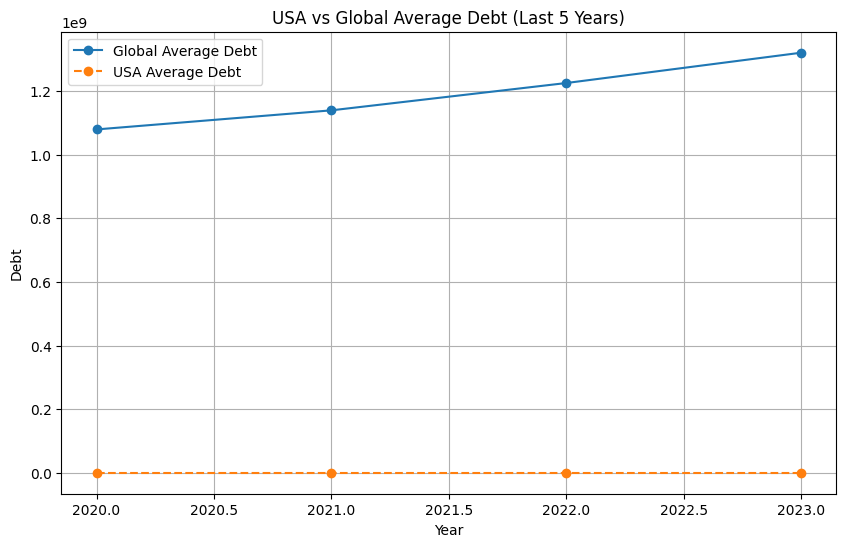

In [33]:
# (c) USA-Specific Analysis
usa_data = combined_data[combined_data['country'] == 'United States']
print("USA Debt Data (Last 5 Years):")
print(usa_data)

# Compare USA's average debt to global averages
global_avg_debt = combined_data.groupby('year')['debt'].mean()
usa_avg_debt = usa_data.groupby('year')['debt'].mean()

comparison = pd.DataFrame({
    'Year': global_avg_debt.index,
    'Global Average Debt': global_avg_debt.values,
    'USA Average Debt': usa_avg_debt.values
})
print("USA vs Global Average Debt Comparison:")
print(comparison)

# Visualization: USA vs Global Average Debt
plt.figure(figsize=(10, 6))
plt.plot(comparison['Year'], comparison['Global Average Debt'], label='Global Average Debt', marker='o')
plt.plot(comparison['Year'], comparison['USA Average Debt'], label='USA Average Debt', marker='o', linestyle='--')
plt.title('USA vs Global Average Debt (Last 5 Years)')
plt.xlabel('Year')
plt.ylabel('Debt')
plt.legend()
plt.grid(True)
plt.show()


In [34]:

# (b) Network Analysis - Correlation between countries
corr_matrix = combined_data.pivot_table(index='year', columns='country', values='debt').corr()
G = nx.Graph()
for i in corr_matrix.index:
    for j in corr_matrix.columns:
        if i != j and corr_matrix.loc[i, j] > 0.7:  # Threshold for high correlation
            G.add_edge(i, j, weight=corr_matrix.loc[i, j])

* Visualizing the network


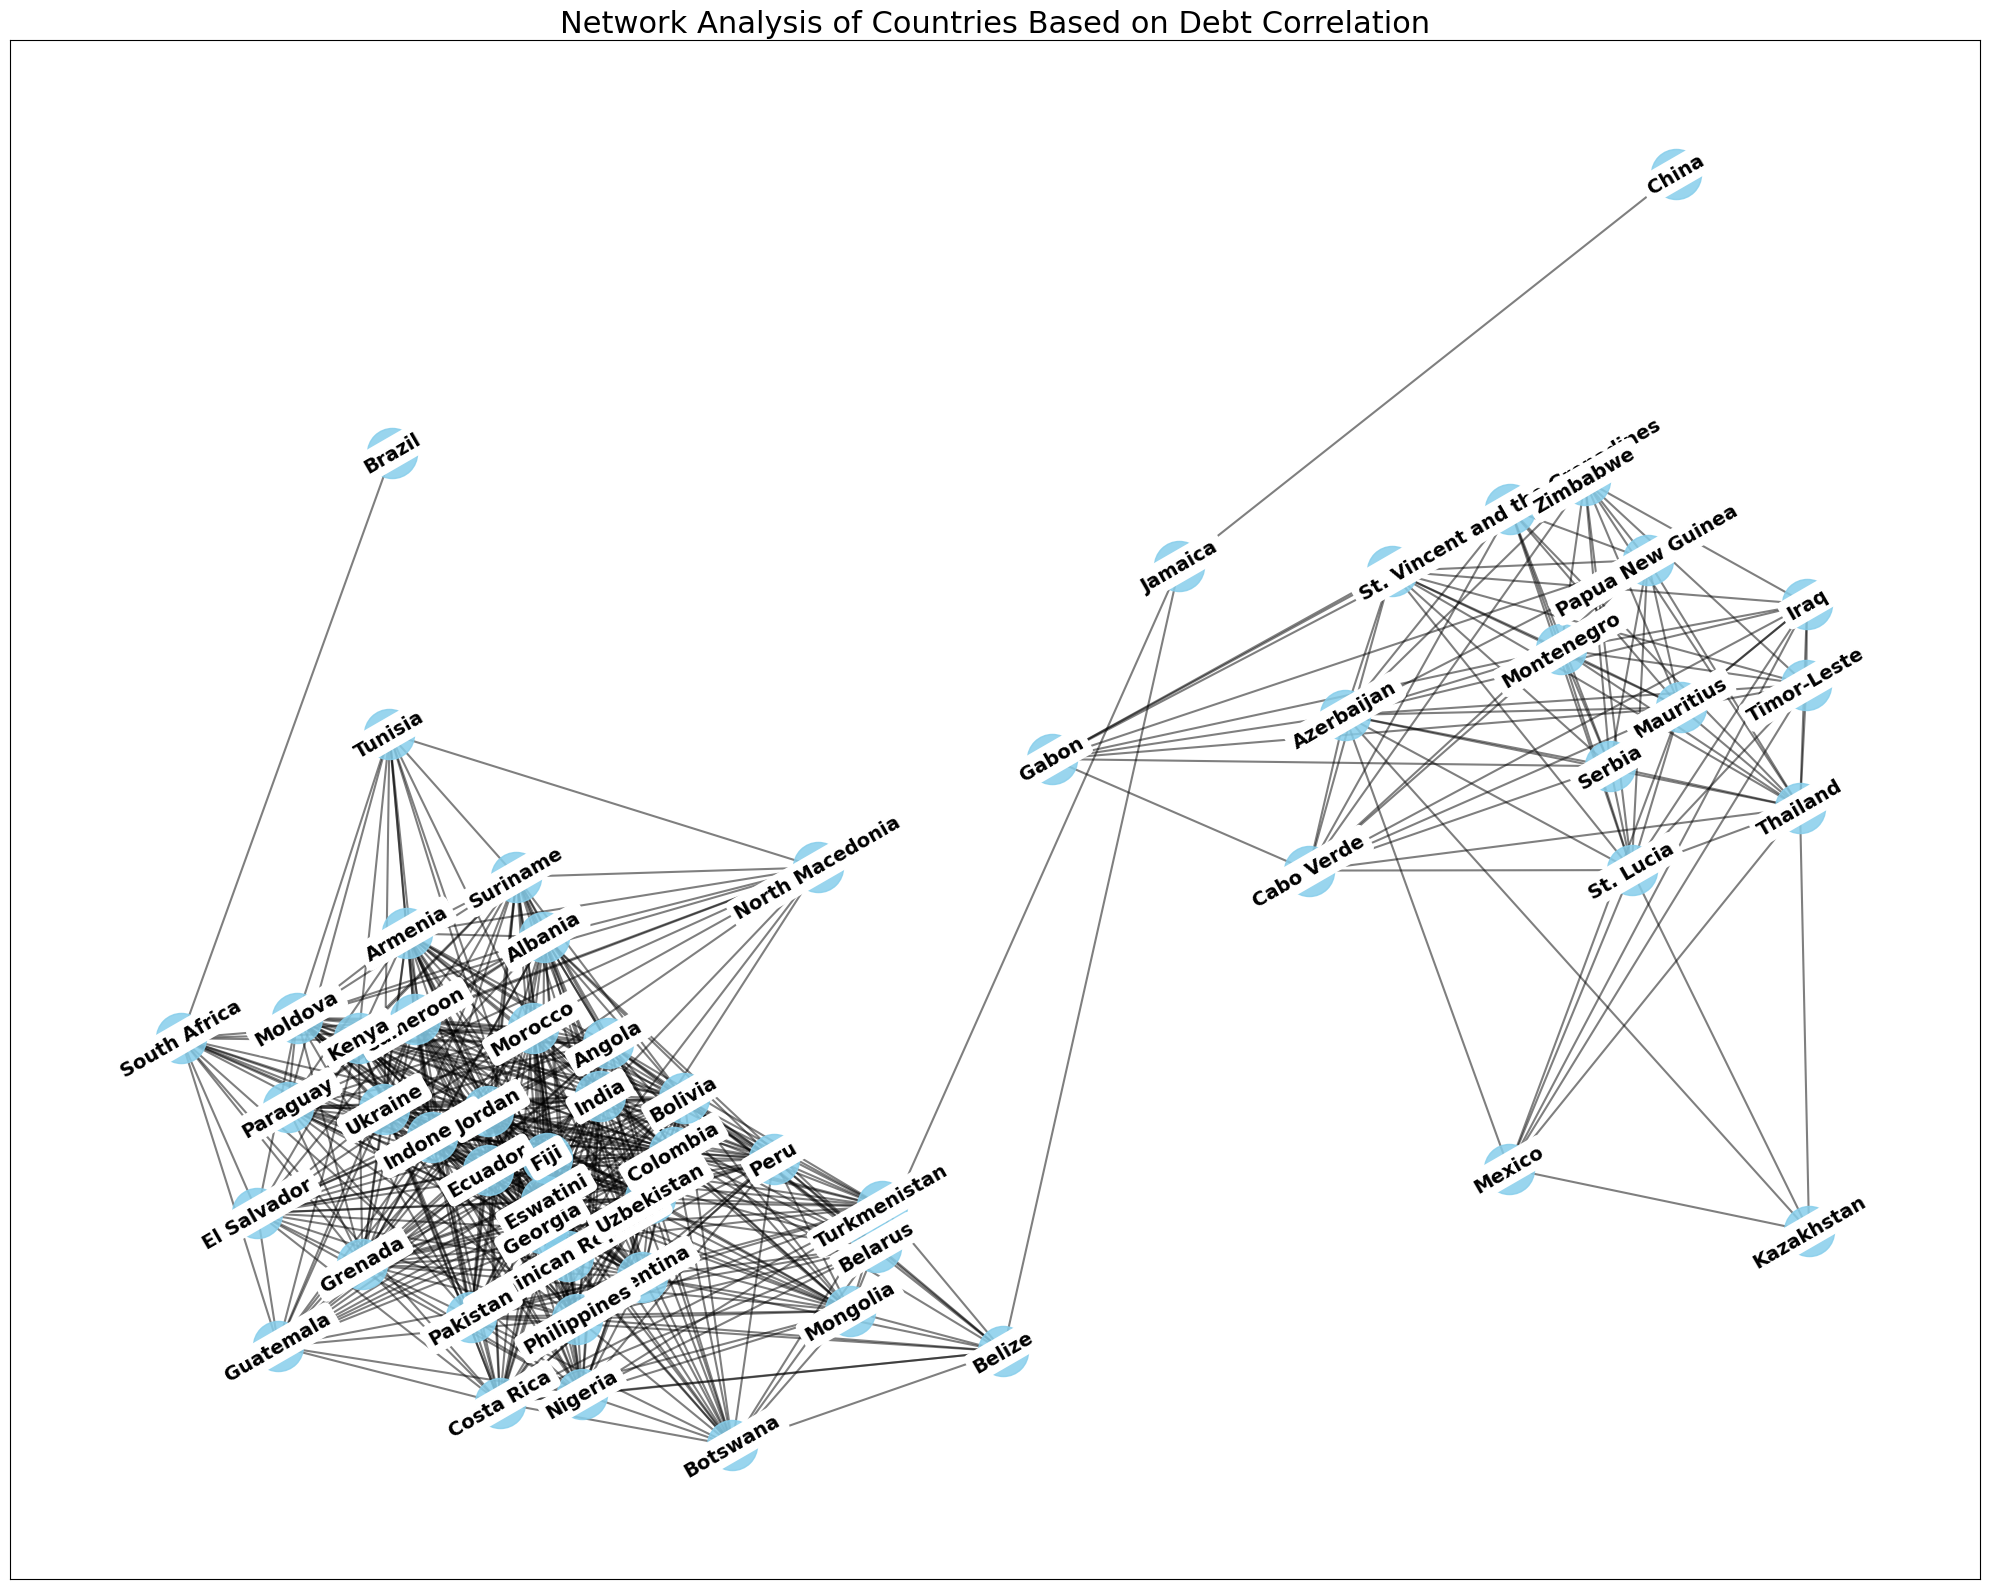

In [35]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(20, 16))  # Increase figure size for better visualization

# Increase k for more space between nodes
pos = nx.spring_layout(G, k=0.8)  

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1300, node_color='skyblue', alpha=0.85)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5)

# Draw labels with bounding boxes and rotation
labels = nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

for _, label in labels.items():
    label.set_rotation(30)  # Rotate labels
    label.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

plt.title("Network Analysis of Countries Based on Debt Correlation", fontsize=22)
plt.tight_layout()
plt.show()


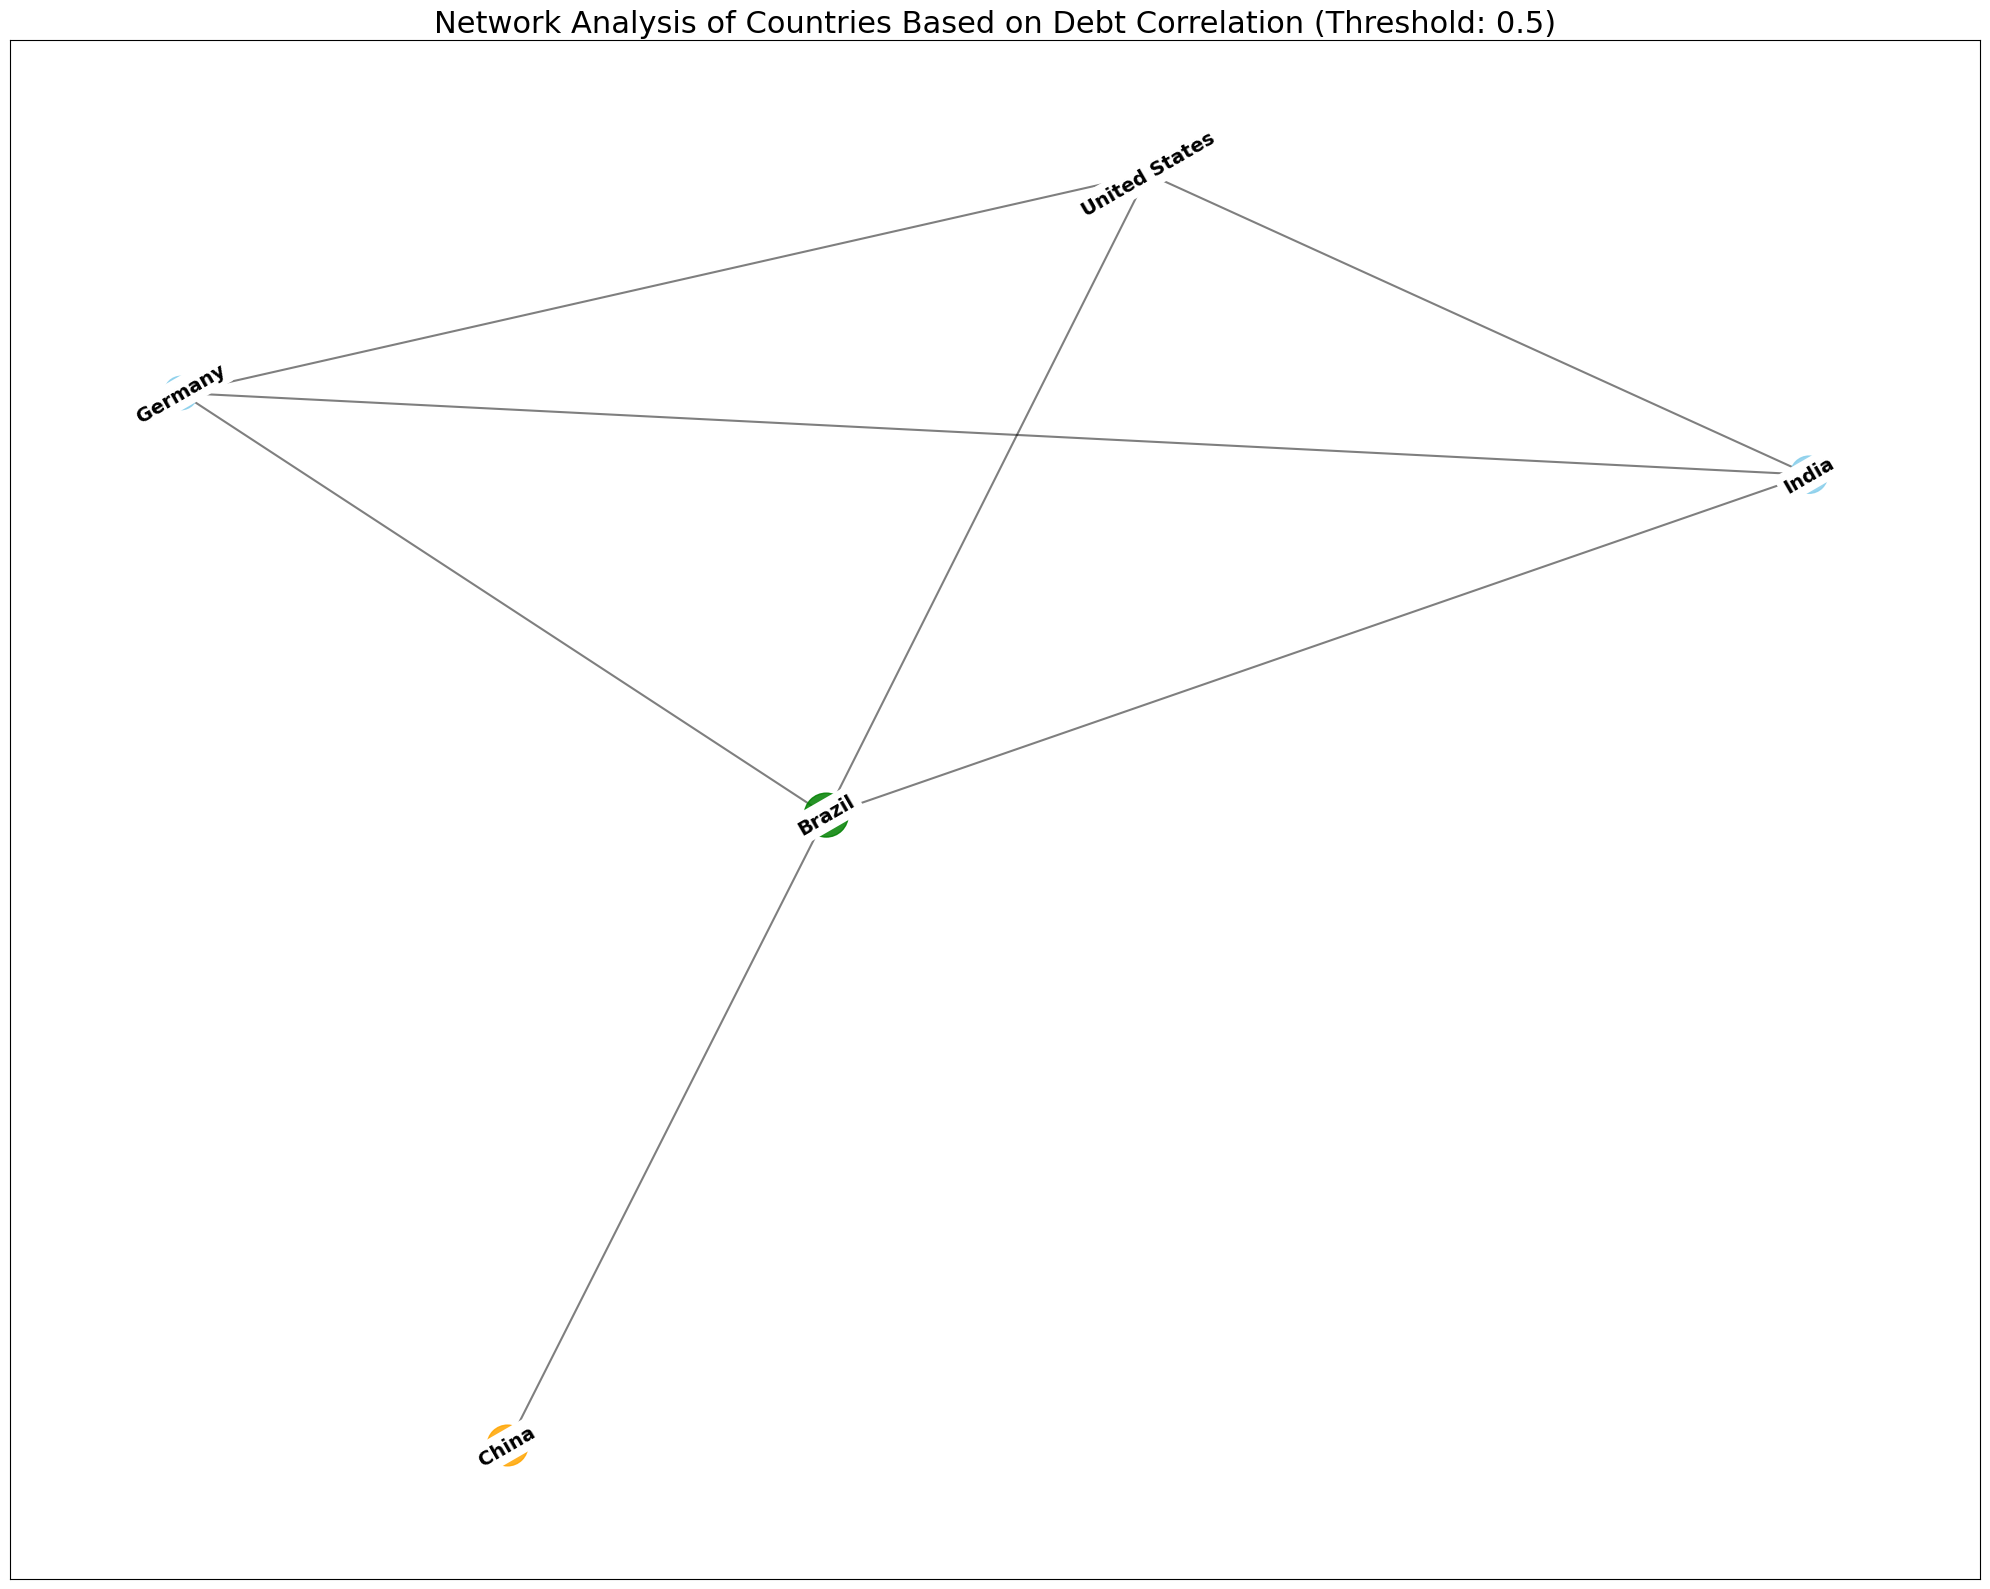

In [36]:

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Example: Create a sample DataFrame for countries and their debt (replace this with your actual data)
data = {'country': ['United States', 'China', 'Brazil', 'Germany', 'India'],
        'debt': [30, 40, 15, 35, 25]}  # Example debt data

combined_data = pd.DataFrame(data)

# Compute the correlation matrix (replace with your actual data correlation)
# For demonstration, we use a synthetic correlation matrix between countries
corr_matrix = pd.DataFrame(np.random.rand(5, 5), columns=combined_data['country'], index=combined_data['country'])

# Set the correlation threshold (lowering this will identify more relationships)
threshold = 0.5  # Adjust this value to find more relationships

# Create a new graph
G = nx.Graph()

# Add edges based on the correlation matrix, only if correlation is above the threshold
for i in corr_matrix.index:
    for j in corr_matrix.columns:
        if i != j and corr_matrix.loc[i, j] > threshold:  # Only add edge if correlation > threshold
            G.add_edge(i, j, weight=corr_matrix.loc[i, j])

# Remove isolated nodes (nodes with no edges)
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

# Check if there are any nodes left after filtering
if len(G.nodes) == 0:
    print("No edges found above the threshold. Try lowering it further.")
else:
    # Node size based on some attribute (e.g., mean debt for each country)
    node_size = combined_data.groupby('country')['debt'].mean()
    node_size = MinMaxScaler(feature_range=(300, 1000)).fit_transform(node_size.values.reshape(-1, 1)).flatten()

    # Color map adjustment
    node_color = ['red' if node == 'United States' else
                  'orange' if node == 'China' else
                  'green' if node == 'Brazil' else
                  'skyblue'
                  for node in G.nodes]

    # Visualization
    plt.figure(figsize=(20, 16))  # Increase figure size for better visualization
    pos = nx.spring_layout(G, k=0.8, seed=42)  # Set positions using spring layout (k controls spacing)

    # Draw nodes with customized sizes and colors
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.85)

    # Draw edges with customized width and transparency
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5)

    # Draw labels with customized font size and weight
    labels = nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

    # Adjust label appearance
    for _, label in labels.items():
        label.set_rotation(30)  # Rotate labels for better visibility
        label.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add background box for labels

    # Title and display
    plt.title(f"Network Analysis of Countries Based on Debt Correlation (Threshold: {threshold})", fontsize=22)
    plt.tight_layout()
    plt.show()



In [37]:
# Step 7: Visualization - PowerBI Dashboard (Guidance for export)
# Save combined data for PowerBI
combined_data.to_csv('debt_analysis_data.csv', index=False)

# Recommended Visuals for PowerBI:
# - Line chart: Global debt trends
# - Bar chart: Top 5 countries by debt per year
# - Heatmap: Correlation matrix of debt levels
# - Network diagram: Relationship of debt between countries

# Step 8: Documentation
# The final report and detailed insights should be documented in markdown or PDF format.
# Use visuals, descriptive analysis, and network analysis findings to provide actionable insights.
